In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import re
import unicodedata
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import Input
from tensorflow.keras.layers import Embedding, LSTM, Dense, TimeDistributed, Layer
from tensorflow.keras import Model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import ReduceLROnPlateau
import nltk
from nltk.tokenize.toktok import ToktokTokenizer
from nltk.corpus import stopwords 
from textblob import TextBlob
from bs4 import BeautifulSoup
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

import warnings
warnings.filterwarnings('ignore')
import nltk.corpus as Corpus

In [2]:
pip install openpyxl==3.0.9

In [6]:
data1 = pd.read_excel("/content/questions.xlsx")
data1.head()

,Unnamed: 0,qid,question
0,0.0,Q0,I am the only son of my father and mother. Rec...
1,1.0,Q1,"Dear mr. / mrs. , we have formed a cricket clu..."
2,2.0,Q2,"Dear Sir, I Just want to know is there any opt..."
3,3.0,Q3,"The Honorable Prime Minister, Sub :- Regarding..."
4,4.0,Q4,"Hello, I am looking for an expert who helps me..."


In [8]:
data2 = pd.read_excel("/content/answers.xlsx")
data2.head()

,Unnamed: 0,aid,answer
0,0.0,A0,Insurance is a contract between the insurance ...
1,1.0,A1,Irrespective of your registration at the crick...
2,2.0,A2,"If your wife has just filed, then until the pr..."
3,3.0,A3,If you are working with LIC as a temporary wor...
4,4.0,A4,When you have signed a contract then you are b...


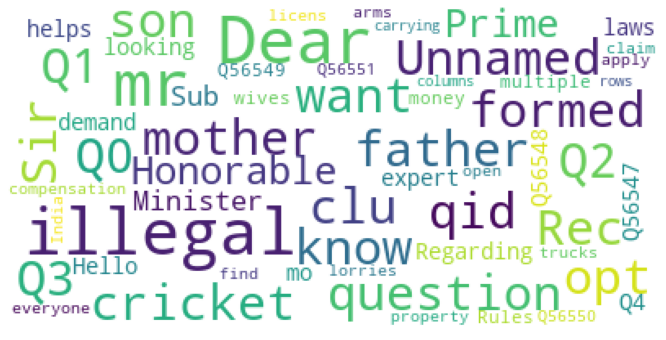

In [9]:
def show_wordcloud(data, title = None):
    wordcloud = WordCloud(background_color = 'white', max_words = 4500, max_font_size = 40, scale = 1, 
                          random_state = 42).generate(str(data))

    fig = plt.figure(1, figsize = (20,6))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize = 20)
        fig.subplots_adjust(top = 2.3)

    plt.imshow(wordcloud)
    plt.show()
    
show_wordcloud(data1)

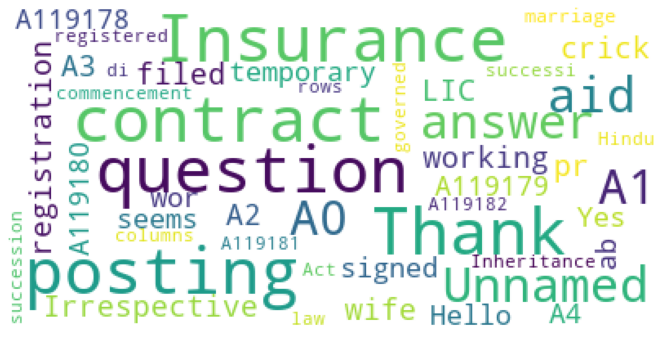

In [10]:
def show_wordcloud(data, title = None):
    wordcloud = WordCloud(background_color = 'white', max_words = 4500, max_font_size = 40, scale = 1, 
                          random_state = 42).generate(str(data))

    fig = plt.figure(1, figsize = (20,6))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize = 20)
        fig.subplots_adjust(top = 2.3)

    plt.imshow(wordcloud)
    plt.show()
    
# print wordcloud
show_wordcloud(data2)

In [11]:
data1['question'] = data1['question'].astype("str").astype("string")

In [12]:
data1['cleaned_text'] = data1['question'].replace(r'\'|\"|\,|\.|\?|\+|\-|\/|\=|\(|\)|\n|"', '', regex = True)

data1['cleaned_text'] = data1['question'].replace("  ", " ")

data1['cleaned_text'] = data1['question'].str.lower()
    
data1['cleaned_text'] = data1['question'].replace(r'^(@\w+)', "", regex = True)
    
data1['cleaned_text'] = data1['question'].replace(r'[^a-zA-Z0-9]', " ", regex = True)

data1['cleaned_text'] = data1['question'].replace(r'[[]!"#$%\'()\*+,-./:;<=>?^_`{|}]+', "", regex = True)

data1['cleaned_text'] = data1['question'].replace(r'https.*$', "", regex = True)

data1['cleaned_text'] = data1['question'].replace(r'amp', "", regex = True)

data1['cleaned_text'] = data1['question'].replace(r'\b[a-zA-Z]{1,2}\b', '', regex = True)

data1['cleaned_text'] = data1['question'].replace(r'^\s+|\s+$', " ", regex = True)

In [13]:
data1['cleaned_text'] = data1['cleaned_text'].astype("string")

In [14]:
def remove_special_characters(text, remove_digits = True):
    pattern = r'[^a-zA-z0-9\s]'
    text = re.sub(pattern,'',text)
    return text

#Apply function on review column
data1['cleaned_text'] = data1['question'].apply(remove_special_characters)

In [16]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [17]:
tokenizer = ToktokTokenizer()

stopword_list = nltk.corpus.stopwords.words('english')

In [18]:
tokenizer = ToktokTokenizer()

stopword_list = nltk.corpus.stopwords.words('english')

In [19]:
def simple_stemmer(text):
    ps = nltk.porter.PorterStemmer()
    text = ' '.join([ps.stem(word) for word in text.split()])
    return text

data1['cleaned_text'] = data1['cleaned_text'].apply(simple_stemmer)

In [20]:
stop = set(stopwords.words('english'))

def remove_stopwords(text, is_lower_case = False):
    tokens = tokenizer.tokenize(text)
    tokens = [token.strip() for token in tokens]
    if is_lower_case:
        filtered_tokens = [token for token in tokens if token not in stopword_list]
    else:
        filtered_tokens = [token for token in tokens if token.lower() not in stopword_list]
    filtered_text = ' '.join(filtered_tokens)    
    return filtered_text


data1['cleaned_text'] = data1['cleaned_text'].apply(remove_stopwords)

In [21]:
data1

,Unnamed: 0,qid,question,cleaned_text
0,0.0,Q0,I am the only son of my father and mother. Rec...,onli son father mother recent father die due l...
1,1.0,Q1,"Dear mr. / mrs. , we have formed a cricket clu...",dear mr mr form cricket club sinc 151215 want ...
2,2.0,Q2,"Dear Sir, I Just want to know is there any opt...",dear sir want know ani option avail appeal sup...
3,3.0,Q3,"The Honorable Prime Minister, Sub :- Regarding...",honor prime minist sub regard case honor supre...
4,4.0,Q4,"Hello, I am looking for an expert who helps me...",hello look expert help surrend pan partnership...
...,...,...,...,...
56547,56547.0,Q56547,What are the laws against illegal demand of mo...,law illeg demand money
56548,56548.0,Q56548,Is it illegal to have multiple wives? Does it ...,illeg multipl wive doe appli accross everi rel...
56549,56549.0,Q56549,Rules on money compensation and property claim...,rule money compens properti claim divorc ani w...
56550,56550.0,Q56550,Can everyone in India apply for an arms licens...,everyon india appli arm licens abov certain age


In [22]:
data2['answer'] = data2['answer'].astype("str").astype("string")

In [23]:
data2['cleaned_text'] = data2['answer'].replace(r'\'|\"|\,|\.|\?|\+|\-|\/|\=|\(|\)|\n|"', '', regex = True)

data2['answer'] = data2['answer'].replace("  ", " ")

data2['cleaned_text'] = data2['answer'].str.lower()
    
data2['cleaned_text'] = data2['answer'].replace(r'^(@\w+)', "", regex = True)
    
data2['cleaned_text'] = data2['answer'].replace(r'[^a-zA-Z0-9]', " ", regex = True)
 
data2['cleaned_text'] = data2['answer'].replace(r'[[]!"#$%\'()\*+,-./:;<=>?^_`{|}]+', "", regex = True)

data2['cleaned_text'] = data2['answer'].replace(r'https.*$', "", regex = True)

data2['cleaned_text'] = data2['answer'].replace(r'amp', "", regex = True)

data2['cleaned_text'] = data2['answer'].replace(r'\b[a-zA-Z]{1,2}\b', '', regex = True)

data2['cleaned_text'] = data2['answer'].replace(r'^\s+|\s+$', " ", regex = True)

In [24]:
data2['cleaned_text'] = data2['cleaned_text'].astype("string")

In [25]:
def remove_special_characters(text, remove_digits = True):
    pattern = r'[^a-zA-z0-9\s]'
    text = re.sub(pattern,'',text)
    return text

#Apply function on review column
data2['cleaned_text'] = data2['answer'].apply(remove_special_characters)

In [26]:
def simple_stemmer(text):
    ps = nltk.porter.PorterStemmer()
    text = ' '.join([ps.stem(word) for word in text.split()])
    return text

data2['cleaned_text'] = data2['cleaned_text'].apply(simple_stemmer)

In [27]:
stop = set(stopwords.words('english'))

def remove_stopwords(text, is_lower_case = False):
    tokens = tokenizer.tokenize(text)
    tokens = [token.strip() for token in tokens]
    if is_lower_case:
        filtered_tokens = [token for token in tokens if token not in stopword_list]
    else:
        filtered_tokens = [token for token in tokens if token.lower() not in stopword_list]
    filtered_text = ' '.join(filtered_tokens)    
    return filtered_text


data2['cleaned_text'] = data2['cleaned_text'].apply(remove_stopwords)

In [28]:
data2

,Unnamed: 0,aid,answer,cleaned_text
0,0.0,A0,Insurance is a contract between the insurance ...,insur contract insur compani life assur everi ...
1,1.0,A1,Irrespective of your registration at the crick...,irrespect registr cricket ground thi need regi...
2,2.0,A2,"If your wife has just filed, then until the pr...",wife ha file proceed final termin high court c...
3,3.0,A3,If you are working with LIC as a temporary wor...,work lic temporari workmen per judgement corpo...
4,4.0,A4,When you have signed a contract then you are b...,sign contract bound term condit break condit l...
...,...,...,...,...
119178,119178.0,A119178,Thanks for posting your question.It seems that...,thank post questionit seem taken unsecur loan ...
119179,119179.0,A119179,"Hello,Thank you posting your question.It is ab...",hellothank post questionit absolut essenti get...
119180,119180.0,A119180,Yes. If the marriage was registered and the di...,ye marriag wa regist divorc wa sought US valid...
119181,119181.0,A119181,After the commencement of Hindu succession Act...,commenc hindu success act 1056 properti hindu ...


In [29]:
data1.drop(['Unnamed: 0'],axis=1,inplace=True)

In [30]:
data2.drop(['Unnamed: 0'],axis=1,inplace=True)

In [31]:
data1

,qid,question,cleaned_text
0,Q0,I am the only son of my father and mother. Rec...,onli son father mother recent father die due l...
1,Q1,"Dear mr. / mrs. , we have formed a cricket clu...",dear mr mr form cricket club sinc 151215 want ...
2,Q2,"Dear Sir, I Just want to know is there any opt...",dear sir want know ani option avail appeal sup...
3,Q3,"The Honorable Prime Minister, Sub :- Regarding...",honor prime minist sub regard case honor supre...
4,Q4,"Hello, I am looking for an expert who helps me...",hello look expert help surrend pan partnership...
...,...,...,...
56547,Q56547,What are the laws against illegal demand of mo...,law illeg demand money
56548,Q56548,Is it illegal to have multiple wives? Does it ...,illeg multipl wive doe appli accross everi rel...
56549,Q56549,Rules on money compensation and property claim...,rule money compens properti claim divorc ani w...
56550,Q56550,Can everyone in India apply for an arms licens...,everyon india appli arm licens abov certain age


In [32]:
data2


,aid,answer,cleaned_text
0,A0,Insurance is a contract between the insurance ...,insur contract insur compani life assur everi ...
1,A1,Irrespective of your registration at the crick...,irrespect registr cricket ground thi need regi...
2,A2,"If your wife has just filed, then until the pr...",wife ha file proceed final termin high court c...
3,A3,If you are working with LIC as a temporary wor...,work lic temporari workmen per judgement corpo...
4,A4,When you have signed a contract then you are b...,sign contract bound term condit break condit l...
...,...,...,...
119178,A119178,Thanks for posting your question.It seems that...,thank post questionit seem taken unsecur loan ...
119179,A119179,"Hello,Thank you posting your question.It is ab...",hellothank post questionit absolut essenti get...
119180,A119180,Yes. If the marriage was registered and the di...,ye marriag wa regist divorc wa sought US valid...
119181,A119181,After the commencement of Hindu succession Act...,commenc hindu success act 1056 properti hindu ...


In [33]:
vector1=np.array(data1)

In [34]:
vector2=np.array(data2)

In [35]:
for i,v in enumerate(data1['cleaned_text'].head(10)):
    print(i,'=>',v)

0 => onli son father mother recent father die due liver chronic diseas lic hous financ ltd ask premium time time limit time otherwis post notic foe sale mother middl class famili incom ourself ani possibl non repay remain amount pleas help
1 => dear mr mr form cricket club sinc 151215 want regist thi societi act india karnataka elect secretari treasur presid thi club form softwar profession grade play repres cricket form earlier life regist thi club cricket ground receiv mail post commun behalf
2 => dear sir want know ani option avail appeal suprem court 125 crpc mainten case current desert wife file case high court gwalior 125 maintenac thank
3 => honor prime minist sub regard case honor suprem court nadu temp full time tem lic emp assn Vs life insur corpor india case 69502009 honor sir honor SC gave judgment date 18th march 2015 absorb class iii class iv termin employe work dure 1985 2001 life insur corpor india non action corpor case wa follow contempt petit 4592015 wherein honor SC

In [36]:
for i,v in enumerate(data2['cleaned_text'].head(20)):
  print(i,'=>',v)

0 => insur contract insur compani life assur everi contract enforc law must involv valid consider thi case premium consider make contract complet insur premium gener express premium per thousand rupe sum assur illustr form tabl premium rate insur compani premium vari across insur plan polici term sum assur age
1 => irrespect registr cricket ground thi need regist kar tion soc registr act welfar associ depend upon regist offic associ jurisdict need regist
2 => wife ha file proceed final termin high court cannot appeal suprem court accord articl 132 134a constitut india appeal befor suprem court file onli high court certifi case involv substanti question law interpret constitut
3 => work lic temporari workmen per judgement corpor ha direct absorb howev work lic work organ thi judgement applic
4 => sign contract bound term condit break condit liabl pay damag per term condit contract consulat quari share aggreement detail us send aggreement us mainl onli comment upon quit job may join sumw

In [37]:
data2['cleaned_text'].isnull().sum()

0

In [38]:
result = pd.concat([data1['cleaned_text'], data2['cleaned_text']], ignore_index=True, sort=False)

In [39]:
result

0         onli son father mother recent father die due l...
1         dear mr mr form cricket club sinc 151215 want ...
2         dear sir want know ani option avail appeal sup...
3         honor prime minist sub regard case honor supre...
4         hello look expert help surrend pan partnership...
                                ...                        
175730    thank post questionit seem taken unsecur loan ...
175731    hellothank post questionit absolut essenti get...
175732    ye marriag wa regist divorc wa sought US valid...
175733    commenc hindu success act 1056 properti hindu ...
175734    inherit govern law success unless father ha cr...
Name: cleaned_text, Length: 175735, dtype: object

In [40]:
from gensim.models import Word2Vec

# Creating data for the model training
train_data=[]
for i in result:
    train_data.append(i.split())

# Training a word2vec model from the given data set
w2v_model = Word2Vec(train_data, size=300, min_count=2,window=5, sg=1,workers=4)

In [41]:
print('Vocabulary size:', len(w2v_model.wv.vocab))

Vocabulary size: 72281


In [42]:
def get_embedding_w2v(doc_tokens):
    embeddings = []
    if len(doc_tokens)<1:
        return np.zeros(300)
    else:
        for tok in doc_tokens:
            if tok in w2v_model.wv.vocab:
                embeddings.append(w2v_model.wv.word_vec(tok))
            else:
                embeddings.append(np.random.rand(300))
        # mean the vectors of individual words to get the vector of the document
        return np.mean(embeddings, axis=0)

# Getting Word2Vec Vectors for Testing Corpus and Queries
result['vector']=result.apply(lambda x :get_embedding_w2v(x.split()))

In [69]:
result['vector']

0         [0.04091084, 0.09338795, 0.1513894, -0.2749166...
1         [-0.11138733244364006, -0.0015470764228996917,...
2         [0.01637612, -0.0019396018, 0.147664, -0.25932...
3         [0.04542902259638177, 0.12808360973132973, 0.1...
4         [-0.042499203, 0.019662185, 0.057179544, -0.25...
                                ...                        
175730    [0.035102156402987805, 0.06455549208038272, 0....
175731    [0.067062, 0.08431459, 0.11726371, -0.32200167...
175732    [0.04621583, 0.03426856, 0.13762558, -0.365468...
175733    [0.06230531, 0.030205742, 0.10048245, -0.39097...
175734    [0.06219594229513514, 0.03816842365035321, 0.1...
Name: cleaned_text, Length: 175735, dtype: object